In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchvision import transforms, models
from torchvision.models import Inception_V3_Weights

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
import time
from tqdm import tqdm
import glob

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing cross entropy loss."""

    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss


In [4]:
class BreakHisDataset(Dataset):
    """BreakHis dataset class for tumor classification."""

    def __init__(self, image_paths: List[str], labels: List[int],
                 transform: Optional[transforms.Compose] = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
class TumorClassifier(nn.Module):
    """Inception-v3-based tumor classifier."""

    def __init__(self, num_classes: int = 2, dropout_rate: float = 0.5):
        super().__init__()

        # Load pretrained Inception-v3 with auxiliary classifier enabled
        self.backbone = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)

        # Replace the final classifier
        # Inception-v3 has fc (final classifier) and AuxLogits.fc (auxiliary classifier)
        self.backbone.fc = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, num_classes)
        )

        # Replace auxiliary classifier as well (used during training)
        self.backbone.AuxLogits.fc = nn.Linear(768, num_classes)

        # Initialize classifier weights
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        """Initialize classifier weights."""
        for m in self.backbone.fc.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        # Initialize auxiliary classifier
        nn.init.normal_(self.backbone.AuxLogits.fc.weight, 0, 0.01)
        nn.init.constant_(self.backbone.AuxLogits.fc.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Always return the outputs as-is from the backbone
        return self.backbone(x)

    def freeze_backbone(self):
        """Freeze backbone parameters except final classifiers."""
        for name, param in self.backbone.named_parameters():
            if 'fc' not in name and 'AuxLogits.fc' not in name:
                param.requires_grad = False

    def unfreeze_last_conv_layers(self, num_layers: int = 4):
        """Unfreeze last few layers of Inception-v3."""
        # Get all parameters
        all_params = list(self.backbone.named_parameters())

        # Find conv/bn parameters in the last few blocks
        target_layers = ['Mixed_7c', 'Mixed_7b', 'Mixed_6e', 'Mixed_6d'][:num_layers]

        for name, param in all_params:
            for target in target_layers:
                if target in name and ('conv' in name or 'bn' in name):
                    param.requires_grad = True


In [6]:
class EarlyStopping:
    """Early stopping utility."""

    def __init__(self, patience: int = 10, min_delta: float = 0.001,
                 mode: str = 'min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score: float):
        if self.best_score is None:
            self.best_score = val_score
        elif self.mode == 'min':
            if val_score < self.best_score - self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1
        else:  # mode == 'max'
            if val_score > self.best_score + self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True


In [7]:
class MetricsCalculator:
    """Utility class for calculating classification metrics."""

    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray,
                         y_pred_proba: np.ndarray) -> Dict[str, float]:
        """Calculate all classification metrics."""

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        f1 = f1_score(y_true, y_pred, average='binary')
        auc_roc = roc_auc_score(y_true, y_pred_proba)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm
        }

    @staticmethod
    def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix"):
        """Plot confusion matrix heatmap."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Benign', 'Malignant'],
                   yticklabels=['Benign', 'Malignant'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

In [8]:
class BreakHisTrainer:
    """Main trainer class for BreakHis dataset."""

    def __init__(self, data_dir: str, batch_size: int = 32,
                 num_workers: int = 4, device: str = 'cuda'):
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Results storage
        self.results = {}

        # Data transforms - Updated for Inception-v3 (299x299 input)
        self.train_transforms = transforms.Compose([
            transforms.Resize(342),  # Slightly larger than 299 for cropping
            transforms.CenterCrop(299),  # Inception-v3 expects 299x299
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                 saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize(342),
            transforms.CenterCrop(299),  # Inception-v3 expects 299x299
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def parse_dataset(self) -> Dict[str, List]:
        """Parse BreakHis dataset structure using glob pattern matching."""
        print("Parsing BreakHis dataset...")

        # Try different possible paths for the dataset
        possible_paths = [
            os.path.join(self.data_dir, 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, 'BreaKHis_v1/histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, 'histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, '**/*.png'),
        ]

        breast_img_paths = []
        for pattern in possible_paths:
            breast_img_paths = glob.glob(pattern, recursive=True)
            if breast_img_paths:
                print(f"Found images using pattern: {pattern}")
                break

        if not breast_img_paths:
            raise FileNotFoundError(f"No PNG files found in {self.data_dir}. Please check the dataset path.")

        print(f"Found {len(breast_img_paths)} image files")

        data_info = {
            'image_paths': [],
            'labels': [],
            'magnifications': [],
            'patient_ids': []
        }

        for img_path in breast_img_paths:
            try:
                # Extract information from path
                path_parts = img_path.split(os.sep)

                # Find benign/malignant classification from path
                if 'benign' in img_path.lower():
                    label = 0  # benign
                elif 'malignant' in img_path.lower():
                    label = 1  # malignant
                else:
                    continue

                # Extract filename for further processing
                filename = os.path.basename(img_path)

                # Extract magnification from filename (format: SOB_B_A-14-22549AB-40-001.png)
                if '-40-' in filename:
                    mag = '40X'
                elif '-100-' in filename:
                    mag = '100X'
                elif '-200-' in filename:
                    mag = '200X'
                elif '-400-' in filename:
                    mag = '400X'
                else:
                    continue

                # Extract patient ID from filename (format: SOB_B_A-14-22549AB-40-001.png)
                # Patient ID is the part before the magnification
                parts = filename.split('-')
                if len(parts) >= 3:
                    patient_id = '-'.join(parts[:3])  # SOB_B_A-14-22549AB
                else:
                    patient_id = filename.split('.')[0]

                data_info['image_paths'].append(img_path)
                data_info['labels'].append(label)
                data_info['magnifications'].append(mag)
                data_info['patient_ids'].append(patient_id)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

        print(f"Successfully parsed {len(data_info['image_paths'])} images")
        print(f"Benign: {len([l for l in data_info['labels'] if l == 0])}")
        print(f"Malignant: {len([l for l in data_info['labels'] if l == 1])}")
        print(f"Magnifications: {set(data_info['magnifications'])}")
        print(f"Unique patients: {len(set(data_info['patient_ids']))}")

        return data_info

    def create_patient_splits(self, data_info: Dict, test_size: float = 0.2,
                            val_size: float = 0.2) -> Dict[str, Dict]:
        """Create patient-level train/val/test splits."""

        # Get unique patients with their labels
        df = pd.DataFrame(data_info)
        patient_labels = df.groupby('patient_ids')['labels'].first().reset_index()

        # First split: train+val vs test
        train_val_patients, test_patients = train_test_split(
            patient_labels['patient_ids'].tolist(),
            test_size=test_size,
            stratify=patient_labels['labels'].tolist(),
            random_state=42
        )

        # Second split: train vs val
        train_val_labels = patient_labels[patient_labels['patient_ids'].isin(train_val_patients)]['labels'].tolist()
        train_patients, val_patients = train_test_split(
            train_val_patients,
            test_size=val_size / (1 - test_size),
            stratify=train_val_labels,
            random_state=42
        )

        # Create splits for each magnification
        magnifications = ['40X', '100X', '200X', '400X', 'All']
        splits = {}

        for mag in magnifications:
            if mag == 'All':
                mag_mask = pd.Series([True] * len(df))
            else:
                mag_mask = df['magnifications'] == mag

            mag_df = df[mag_mask]

            train_mask = mag_df['patient_ids'].isin(train_patients)
            val_mask = mag_df['patient_ids'].isin(val_patients)
            test_mask = mag_df['patient_ids'].isin(test_patients)

            splits[mag] = {
                'train': {
                    'image_paths': mag_df[train_mask]['image_paths'].tolist(),
                    'labels': mag_df[train_mask]['labels'].tolist()
                },
                'val': {
                    'image_paths': mag_df[val_mask]['image_paths'].tolist(),
                    'labels': mag_df[val_mask]['labels'].tolist()
                },
                'test': {
                    'image_paths': mag_df[test_mask]['image_paths'].tolist(),
                    'labels': mag_df[test_mask]['labels'].tolist()
                }
            }

            print(f"\n{mag} - Train: {len(splits[mag]['train']['labels'])}, "
                  f"Val: {len(splits[mag]['val']['labels'])}, "
                  f"Test: {len(splits[mag]['test']['labels'])}")

        return splits

    def create_data_loaders(self, splits: Dict, magnification: str) -> Dict[str, DataLoader]:
        """Create data loaders for a specific magnification."""

        split_data = splits[magnification]

        # Create datasets
        train_dataset = BreakHisDataset(
            split_data['train']['image_paths'],
            split_data['train']['labels'],
            self.train_transforms
        )

        val_dataset = BreakHisDataset(
            split_data['val']['image_paths'],
            split_data['val']['labels'],
            self.val_transforms
        )

        test_dataset = BreakHisDataset(
            split_data['test']['image_paths'],
            split_data['test']['labels'],
            self.val_transforms
        )

        # Handle class imbalance with weighted sampling
        train_labels = split_data['train']['labels']
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(train_labels),
            y=train_labels
        )

        sample_weights = [class_weights[label] for label in train_labels]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            sampler=sampler,
            num_workers=self.num_workers,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        return {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader
        }

    def train_epoch(self, model: nn.Module, train_loader: DataLoader,
                   criterion: nn.Module, optimizer: torch.optim.Optimizer) -> float:
        """Train for one epoch."""
        model.train()
        total_loss = 0.0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training")):
            images, labels = images.to(self.device), labels.to(self.device)

            optimizer.zero_grad()

            # Handle auxiliary output during training
            outputs = model(images)
            if isinstance(outputs, tuple):
                main_outputs, aux_outputs = outputs
                # Combine main loss and auxiliary loss (weighted)
                main_loss = criterion(main_outputs, labels)
                aux_loss = criterion(aux_outputs, labels)
                loss = main_loss + 0.4 * aux_loss  # Standard Inception-v3 weighting
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def validate_epoch(self, model: nn.Module, val_loader: DataLoader,
                      criterion: nn.Module) -> Tuple[float, float]:
        """Validate for one epoch."""
        model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = model(images)

                # Handle tuple output during validation
                if isinstance(outputs, tuple):
                    main_outputs, _ = outputs
                    outputs = main_outputs

                loss = criterion(outputs, labels)
                total_loss += loss.item()

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of malignant

        avg_loss = total_loss / len(val_loader)
        auc_roc = roc_auc_score(all_labels, all_probs)

        return avg_loss, auc_roc

    def test_model(self, model: nn.Module, test_loader: DataLoader) -> Dict[str, float]:
        """Test the model and return metrics."""
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = model(images)

                # Handle tuple output during testing
                if isinstance(outputs, tuple):
                    main_outputs, _ = outputs
                    outputs = main_outputs

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())

        return MetricsCalculator.calculate_metrics(
            np.array(all_labels),
            np.array(all_preds),
            np.array(all_probs)
        )

    def train_magnification(self, splits: Dict, magnification: str,
                          epochs: int = 100) -> Dict[str, float]:
        """Train model for a specific magnification."""

        print(f"\n{'='*60}")
        print(f"Training on {magnification} magnification with Inception-v3")
        print(f"{'='*60}")

        # Create data loaders
        data_loaders = self.create_data_loaders(splits, magnification)

        # Initialize model
        model = TumorClassifier(num_classes=2, dropout_rate=0.5)
        model.to(self.device)

        # Loss function
        criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

        # Phase 1: Train classifier head with frozen backbone
        print("\nPhase 1: Training classifier head (frozen backbone)")
        model.freeze_backbone()

        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=0.001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10, mode='max')

        best_auc = 0.0
        best_model_state = None

        for epoch in range(epochs // 2):
            # Training
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            # Validation
            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model from Phase 1
        model.load_state_dict(best_model_state)

        # Phase 2: Fine-tune with unfrozen last conv layers
        print("\nPhase 2: Fine-tuning with unfrozen last conv layers")
        model.unfreeze_last_conv_layers(num_layers=4)

        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=0.0001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10, mode='max')

        for epoch in range(epochs // 2):
            # Training
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            # Validation
            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model and test
        model.load_state_dict(best_model_state)
        test_metrics = self.test_model(model, data_loaders['test'])

        print(f"\nBest validation AUC: {best_auc:.4f}")
        print(f"Test metrics:")
        for metric, value in test_metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric}: {value:.4f}")

        # Plot confusion matrix
        cm = test_metrics['confusion_matrix']
        MetricsCalculator.plot_confusion_matrix(cm, f"Confusion Matrix - {magnification} (Inception-v3)")

        return test_metrics

    def run_all_experiments(self, data_dir: str) -> pd.DataFrame:
        """Run experiments for all magnifications."""

        print("Starting BreakHis tumor classification experiments with Inception-v3...")

        # Parse dataset
        data_info = self.parse_dataset()

        # Create patient-level splits
        splits = self.create_patient_splits(data_info)

        # Run experiments for each magnification
        magnifications = ['40X', '100X', '200X', '400X', 'All']
        results = []

        for mag in magnifications:
            print(f"\nStarting experiment for {mag}...")
            metrics = self.train_magnification(splits, mag)

            result = {
                'Magnification': mag,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'Specificity': metrics['specificity'],
                'F1': metrics['f1'],
                'AUC-ROC': metrics['auc_roc']
            }
            results.append(result)

            # Store confusion matrix separately
            self.results[mag] = {
                'metrics': result,
                'confusion_matrix': metrics['confusion_matrix']
            }

        # Create results DataFrame
        results_df = pd.DataFrame(results)

        # Display results table
        print("\n" + "="*80)
        print("FINAL RESULTS TABLE - Inception-v3")
        print("="*80)
        print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

        return results_df


In [9]:
def main():
    """Main function to run the experiments."""

    # Download dataset using kagglehub
    import kagglehub

    # Download dataset
    path = kagglehub.dataset_download("ambarish/breakhis")
    print("Path to dataset files:", path)

    # Configuration
    DATA_DIR = path  # Use the downloaded path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f"Using device: {DEVICE}")
    print("Using Inception-v3 backbone")

    # Initialize trainer
    trainer = BreakHisTrainer(
        data_dir=DATA_DIR,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        device=DEVICE
    )

    # Run all experiments
    results_df = trainer.run_all_experiments(DATA_DIR)

    # Save results
    results_df.to_csv('breakhis_inception_v3_results.csv', index=False)
    print("\nResults saved to 'breakhis_inception_v3_results.csv'")

    # Display final summary
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY - Inception-v3")
    print("="*80)
    print(f"Average Accuracy: {results_df['Accuracy'].mean():.4f}")
    print(f"Average AUC-ROC: {results_df['AUC-ROC'].mean():.4f}")
    print(f"Best performing magnification: {results_df.loc[results_df['Accuracy'].idxmax(), 'Magnification']}")

    return results_df

Path to dataset files: /kaggle/input/breakhis
Using device: cuda
Using Inception-v3 backbone
Starting BreakHis tumor classification experiments with Inception-v3...
Parsing BreakHis dataset...
Found images using pattern: /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png
Found 7909 image files
Successfully parsed 7909 images
Benign: 2480
Malignant: 5429
Magnifications: {'200X', '400X', '40X', '100X'}
Unique patients: 82

40X - Train: 1172, Val: 382, Test: 441

100X - Train: 1201, Val: 403, Test: 477

200X - Train: 1188, Val: 382, Test: 443

400X - Train: 1059, Val: 367, Test: 394

All - Train: 4620, Val: 1534, Test: 1755

Starting experiment for 40X...

Training on 40X magnification with Inception-v3


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 194MB/s] 



Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch   1: Train Loss: 1.1232, Val Loss: 0.6196, Val AUC: 0.7407


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch   2: Train Loss: 0.8153, Val Loss: 0.5922, Val AUC: 0.7377


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   3: Train Loss: 0.7994, Val Loss: 0.5640, Val AUC: 0.7648


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch   4: Train Loss: 0.7677, Val Loss: 0.6570, Val AUC: 0.7692


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch   5: Train Loss: 0.7893, Val Loss: 0.5740, Val AUC: 0.7882


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch   6: Train Loss: 0.7546, Val Loss: 0.7003, Val AUC: 0.7762


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   7: Train Loss: 0.7685, Val Loss: 0.5767, Val AUC: 0.7553


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch   8: Train Loss: 0.7755, Val Loss: 0.5717, Val AUC: 0.7890


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch   9: Train Loss: 0.7649, Val Loss: 0.5679, Val AUC: 0.7757


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch  10: Train Loss: 0.7539, Val Loss: 0.5626, Val AUC: 0.7959


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch  11: Train Loss: 0.7318, Val Loss: 0.5900, Val AUC: 0.7836


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch  12: Train Loss: 0.7395, Val Loss: 0.5898, Val AUC: 0.7908


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch  13: Train Loss: 0.7361, Val Loss: 0.5919, Val AUC: 0.8012


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch  14: Train Loss: 0.7749, Val Loss: 0.6552, Val AUC: 0.7886


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch  15: Train Loss: 0.7603, Val Loss: 0.6129, Val AUC: 0.7882


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch  16: Train Loss: 0.7277, Val Loss: 0.5714, Val AUC: 0.7880


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch  17: Train Loss: 0.7359, Val Loss: 0.5749, Val AUC: 0.8227


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  18: Train Loss: 0.7465, Val Loss: 0.6117, Val AUC: 0.7816


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  19: Train Loss: 0.7463, Val Loss: 0.6237, Val AUC: 0.7868


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch  20: Train Loss: 0.7411, Val Loss: 0.6425, Val AUC: 0.7750


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  21: Train Loss: 0.7279, Val Loss: 0.6609, Val AUC: 0.7998


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch  22: Train Loss: 0.7508, Val Loss: 0.5813, Val AUC: 0.7719


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  23: Train Loss: 0.7291, Val Loss: 0.7652, Val AUC: 0.7918


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch  24: Train Loss: 0.7253, Val Loss: 0.5715, Val AUC: 0.7933


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch  25: Train Loss: 0.7358, Val Loss: 0.6119, Val AUC: 0.7986


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  26: Train Loss: 0.7324, Val Loss: 0.6133, Val AUC: 0.7773


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  27: Train Loss: 0.7307, Val Loss: 0.6013, Val AUC: 0.7884
Early stopping at epoch 27

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch   1: Train Loss: 0.6602, Val Loss: 0.5365, Val AUC: 0.8717


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   2: Train Loss: 0.6197, Val Loss: 0.5459, Val AUC: 0.8245


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch   3: Train Loss: 0.5898, Val Loss: 0.5003, Val AUC: 0.8987


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch   4: Train Loss: 0.5596, Val Loss: 0.5095, Val AUC: 0.8902


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch   5: Train Loss: 0.5493, Val Loss: 0.4762, Val AUC: 0.9314


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch   6: Train Loss: 0.5367, Val Loss: 0.4506, Val AUC: 0.9440


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   7: Train Loss: 0.5216, Val Loss: 0.4882, Val AUC: 0.8986


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   8: Train Loss: 0.5163, Val Loss: 0.4905, Val AUC: 0.9350


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch   9: Train Loss: 0.5069, Val Loss: 0.4760, Val AUC: 0.9323


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Epoch  10: Train Loss: 0.5205, Val Loss: 0.4918, Val AUC: 0.9388


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch  11: Train Loss: 0.5103, Val Loss: 0.5075, Val AUC: 0.8668


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch  12: Train Loss: 0.5021, Val Loss: 0.5016, Val AUC: 0.8795


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  13: Train Loss: 0.5002, Val Loss: 0.4719, Val AUC: 0.9385


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  14: Train Loss: 0.4929, Val Loss: 0.4903, Val AUC: 0.9005


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  15: Train Loss: 0.4897, Val Loss: 0.4833, Val AUC: 0.9086


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch  16: Train Loss: 0.4900, Val Loss: 0.4992, Val AUC: 0.8389
Early stopping at epoch 16


Testing: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]



Best validation AUC: 0.9440
Test metrics:
  accuracy: 0.8095
  precision: 0.8114
  recall: 0.8803
  specificity: 0.7088
  f1: 0.8444
  auc_roc: 0.8327


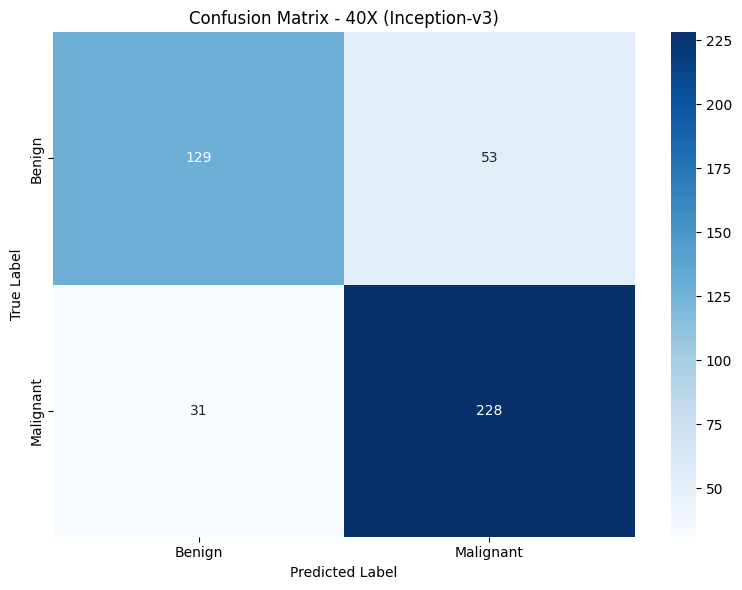


Starting experiment for 100X...

Training on 100X magnification with Inception-v3

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


Epoch   1: Train Loss: 1.0892, Val Loss: 0.6579, Val AUC: 0.6794


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch   2: Train Loss: 0.8783, Val Loss: 0.6095, Val AUC: 0.6911


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch   3: Train Loss: 0.8214, Val Loss: 0.6089, Val AUC: 0.7044


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


Epoch   4: Train Loss: 0.7902, Val Loss: 0.6654, Val AUC: 0.7090


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch   5: Train Loss: 0.7901, Val Loss: 0.5822, Val AUC: 0.7340


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch   6: Train Loss: 0.7883, Val Loss: 0.6266, Val AUC: 0.7396


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch   7: Train Loss: 0.7802, Val Loss: 0.6355, Val AUC: 0.7602


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


Epoch   8: Train Loss: 0.7903, Val Loss: 0.5865, Val AUC: 0.7515


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


Epoch   9: Train Loss: 0.7730, Val Loss: 0.5934, Val AUC: 0.7726


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Epoch  10: Train Loss: 0.7584, Val Loss: 0.5820, Val AUC: 0.7641


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


Epoch  11: Train Loss: 0.7601, Val Loss: 0.5988, Val AUC: 0.7720


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch  12: Train Loss: 0.7421, Val Loss: 0.5990, Val AUC: 0.7737


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch  13: Train Loss: 0.7439, Val Loss: 0.6354, Val AUC: 0.7473


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch  14: Train Loss: 0.7525, Val Loss: 0.5719, Val AUC: 0.7848


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


Epoch  15: Train Loss: 0.7494, Val Loss: 0.6114, Val AUC: 0.7669


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]


Epoch  16: Train Loss: 0.7541, Val Loss: 0.6609, Val AUC: 0.7774


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch  17: Train Loss: 0.7502, Val Loss: 0.5753, Val AUC: 0.7905


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


Epoch  18: Train Loss: 0.7442, Val Loss: 0.6014, Val AUC: 0.7801


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


Epoch  19: Train Loss: 0.7449, Val Loss: 0.5954, Val AUC: 0.7809


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch  20: Train Loss: 0.7518, Val Loss: 0.5786, Val AUC: 0.7946


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


Epoch  21: Train Loss: 0.7433, Val Loss: 0.5784, Val AUC: 0.7825


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


Epoch  22: Train Loss: 0.7303, Val Loss: 0.5810, Val AUC: 0.7825


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch  23: Train Loss: 0.7299, Val Loss: 0.5668, Val AUC: 0.7905


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


Epoch  24: Train Loss: 0.7546, Val Loss: 0.5727, Val AUC: 0.7806


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


Epoch  25: Train Loss: 0.7418, Val Loss: 0.6001, Val AUC: 0.7844


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch  26: Train Loss: 0.7592, Val Loss: 0.6525, Val AUC: 0.7828


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch  27: Train Loss: 0.7264, Val Loss: 0.5957, Val AUC: 0.7864


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Epoch  28: Train Loss: 0.7409, Val Loss: 0.5883, Val AUC: 0.7711


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]


Epoch  29: Train Loss: 0.7341, Val Loss: 0.5736, Val AUC: 0.7951


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Epoch  30: Train Loss: 0.7210, Val Loss: 0.5859, Val AUC: 0.7801
Early stopping at epoch 30

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


Epoch   1: Train Loss: 0.6908, Val Loss: 0.5473, Val AUC: 0.8570


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch   2: Train Loss: 0.6301, Val Loss: 0.5644, Val AUC: 0.8280


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


Epoch   3: Train Loss: 0.6009, Val Loss: 0.5606, Val AUC: 0.8442


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch   4: Train Loss: 0.5522, Val Loss: 0.5390, Val AUC: 0.8700


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.08it/s]


Epoch   5: Train Loss: 0.5551, Val Loss: 0.5369, Val AUC: 0.8826


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]


Epoch   6: Train Loss: 0.5435, Val Loss: 0.5555, Val AUC: 0.8378


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch   7: Train Loss: 0.5417, Val Loss: 0.5524, Val AUC: 0.8814


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch   8: Train Loss: 0.5351, Val Loss: 0.5451, Val AUC: 0.8800


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch   9: Train Loss: 0.5268, Val Loss: 0.5581, Val AUC: 0.8425


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch  10: Train Loss: 0.5402, Val Loss: 0.5437, Val AUC: 0.8766


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch  11: Train Loss: 0.5165, Val Loss: 0.5498, Val AUC: 0.8434


Validation: 100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


Epoch  12: Train Loss: 0.5083, Val Loss: 0.5531, Val AUC: 0.8492


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


Epoch  13: Train Loss: 0.5045, Val Loss: 0.5500, Val AUC: 0.8633


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch  14: Train Loss: 0.4960, Val Loss: 0.5707, Val AUC: 0.8395


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch  15: Train Loss: 0.5005, Val Loss: 0.5540, Val AUC: 0.8449
Early stopping at epoch 15


Testing: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s]



Best validation AUC: 0.8826
Test metrics:
  accuracy: 0.8700
  precision: 0.9066
  recall: 0.8822
  specificity: 0.8500
  f1: 0.8942
  auc_roc: 0.9387


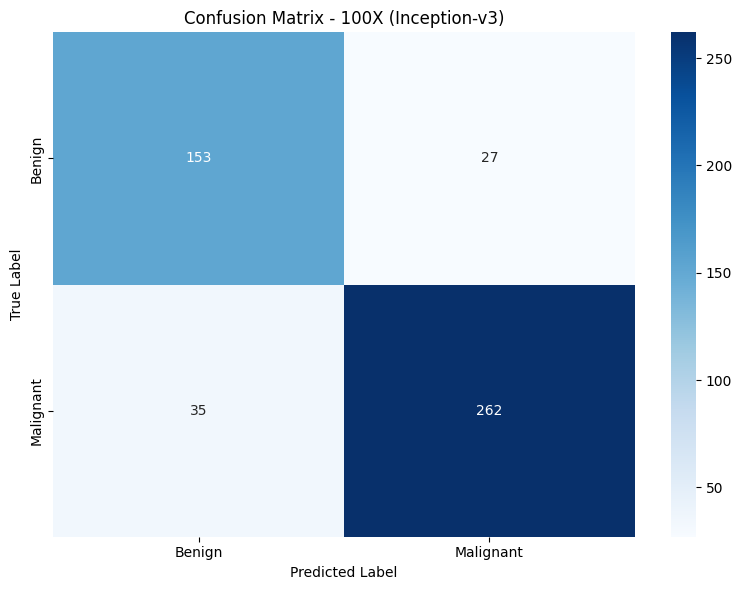


Starting experiment for 200X...

Training on 200X magnification with Inception-v3

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Epoch   1: Train Loss: 1.0848, Val Loss: 0.7312, Val AUC: 0.7903


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch   2: Train Loss: 0.8184, Val Loss: 0.5966, Val AUC: 0.7323


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch   3: Train Loss: 0.8108, Val Loss: 0.5725, Val AUC: 0.7913


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   4: Train Loss: 0.7710, Val Loss: 0.6345, Val AUC: 0.8184


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch   5: Train Loss: 0.7731, Val Loss: 0.5623, Val AUC: 0.8178


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch   6: Train Loss: 0.7789, Val Loss: 0.6361, Val AUC: 0.8156


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Epoch   7: Train Loss: 0.7714, Val Loss: 0.5630, Val AUC: 0.8120


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch   8: Train Loss: 0.7835, Val Loss: 0.5900, Val AUC: 0.8058


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch   9: Train Loss: 0.7562, Val Loss: 0.5827, Val AUC: 0.7701


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch  10: Train Loss: 0.7675, Val Loss: 0.5844, Val AUC: 0.8061


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Epoch  11: Train Loss: 0.7322, Val Loss: 0.5968, Val AUC: 0.8205


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch  12: Train Loss: 0.7581, Val Loss: 0.5644, Val AUC: 0.8157


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch  13: Train Loss: 0.7536, Val Loss: 0.5663, Val AUC: 0.8157


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  14: Train Loss: 0.7295, Val Loss: 0.5744, Val AUC: 0.8122


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch  15: Train Loss: 0.7397, Val Loss: 0.5805, Val AUC: 0.8427


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


Epoch  16: Train Loss: 0.7019, Val Loss: 0.5912, Val AUC: 0.8351


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch  17: Train Loss: 0.7315, Val Loss: 0.5587, Val AUC: 0.8161


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch  18: Train Loss: 0.7474, Val Loss: 0.5627, Val AUC: 0.8370


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch  19: Train Loss: 0.7494, Val Loss: 0.5569, Val AUC: 0.8265


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  20: Train Loss: 0.7309, Val Loss: 0.5567, Val AUC: 0.8254


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch  21: Train Loss: 0.7264, Val Loss: 0.5822, Val AUC: 0.8288


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  22: Train Loss: 0.7240, Val Loss: 0.5554, Val AUC: 0.8354


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch  23: Train Loss: 0.7493, Val Loss: 0.5680, Val AUC: 0.8308


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch  24: Train Loss: 0.7179, Val Loss: 0.5508, Val AUC: 0.8374


Validation: 100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Epoch  25: Train Loss: 0.7332, Val Loss: 0.5526, Val AUC: 0.8416
Early stopping at epoch 25

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch   1: Train Loss: 0.6748, Val Loss: 0.6415, Val AUC: 0.8054


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   2: Train Loss: 0.6362, Val Loss: 0.5879, Val AUC: 0.8764


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch   3: Train Loss: 0.6004, Val Loss: 0.5268, Val AUC: 0.8906


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch   4: Train Loss: 0.5669, Val Loss: 0.5573, Val AUC: 0.9092


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch   5: Train Loss: 0.5682, Val Loss: 0.5357, Val AUC: 0.9013


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch   6: Train Loss: 0.5523, Val Loss: 0.5010, Val AUC: 0.9222


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch   7: Train Loss: 0.5564, Val Loss: 0.5139, Val AUC: 0.9113


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch   8: Train Loss: 0.5320, Val Loss: 0.5240, Val AUC: 0.8896


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   9: Train Loss: 0.5230, Val Loss: 0.5040, Val AUC: 0.9214


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch  10: Train Loss: 0.5457, Val Loss: 0.5112, Val AUC: 0.9162


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  11: Train Loss: 0.5265, Val Loss: 0.5371, Val AUC: 0.8838


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  12: Train Loss: 0.5127, Val Loss: 0.4923, Val AUC: 0.9236


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch  13: Train Loss: 0.5177, Val Loss: 0.4937, Val AUC: 0.9100


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  14: Train Loss: 0.5309, Val Loss: 0.5033, Val AUC: 0.9287


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  15: Train Loss: 0.5251, Val Loss: 0.4975, Val AUC: 0.8927


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch  16: Train Loss: 0.5162, Val Loss: 0.5089, Val AUC: 0.8973


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  17: Train Loss: 0.5088, Val Loss: 0.4764, Val AUC: 0.9190


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch  18: Train Loss: 0.5134, Val Loss: 0.5286, Val AUC: 0.8511


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch  19: Train Loss: 0.5114, Val Loss: 0.5266, Val AUC: 0.8945


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  20: Train Loss: 0.4975, Val Loss: 0.5172, Val AUC: 0.8893


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch  21: Train Loss: 0.5036, Val Loss: 0.5030, Val AUC: 0.9155


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  22: Train Loss: 0.5210, Val Loss: 0.5281, Val AUC: 0.8604


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch  23: Train Loss: 0.4922, Val Loss: 0.5132, Val AUC: 0.8986


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  24: Train Loss: 0.4973, Val Loss: 0.5078, Val AUC: 0.8967
Early stopping at epoch 24


Testing: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]



Best validation AUC: 0.9287
Test metrics:
  accuracy: 0.7765
  precision: 0.7825
  recall: 0.8828
  specificity: 0.6059
  f1: 0.8296
  auc_roc: 0.7904


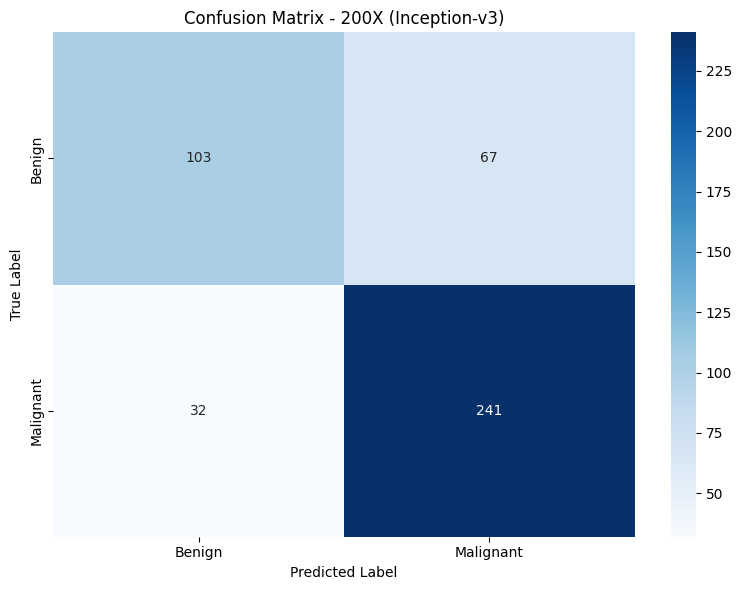


Starting experiment for 400X...

Training on 400X magnification with Inception-v3

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch   1: Train Loss: 1.0919, Val Loss: 0.5607, Val AUC: 0.8253


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   2: Train Loss: 0.8964, Val Loss: 0.7767, Val AUC: 0.8351


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch   3: Train Loss: 0.8639, Val Loss: 0.5438, Val AUC: 0.8567


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Epoch   4: Train Loss: 0.8366, Val Loss: 0.5253, Val AUC: 0.8670


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   5: Train Loss: 0.8123, Val Loss: 0.6392, Val AUC: 0.8676


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch   6: Train Loss: 0.8255, Val Loss: 0.5436, Val AUC: 0.8712


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   7: Train Loss: 0.7922, Val Loss: 0.5780, Val AUC: 0.8752


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch   8: Train Loss: 0.8039, Val Loss: 0.5738, Val AUC: 0.8701


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch   9: Train Loss: 0.8208, Val Loss: 0.7145, Val AUC: 0.8731


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch  10: Train Loss: 0.7731, Val Loss: 0.5477, Val AUC: 0.8817


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch  11: Train Loss: 0.7853, Val Loss: 0.5285, Val AUC: 0.8647


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  12: Train Loss: 0.8194, Val Loss: 0.5838, Val AUC: 0.8747


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  13: Train Loss: 0.7662, Val Loss: 0.5171, Val AUC: 0.8771


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch  14: Train Loss: 0.8192, Val Loss: 0.6048, Val AUC: 0.8808


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  15: Train Loss: 0.7843, Val Loss: 0.5833, Val AUC: 0.8715


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  16: Train Loss: 0.7879, Val Loss: 0.5179, Val AUC: 0.8815


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch  17: Train Loss: 0.7888, Val Loss: 0.5453, Val AUC: 0.8850


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  18: Train Loss: 0.7708, Val Loss: 0.5239, Val AUC: 0.8792


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch  19: Train Loss: 0.7735, Val Loss: 0.5643, Val AUC: 0.8757


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch  20: Train Loss: 0.7548, Val Loss: 0.5713, Val AUC: 0.8800


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  21: Train Loss: 0.7689, Val Loss: 0.5431, Val AUC: 0.8721


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch  22: Train Loss: 0.7871, Val Loss: 0.6553, Val AUC: 0.8898


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch  23: Train Loss: 0.7739, Val Loss: 0.5270, Val AUC: 0.8742


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch  24: Train Loss: 0.7561, Val Loss: 0.6027, Val AUC: 0.8855


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch  25: Train Loss: 0.7539, Val Loss: 0.5497, Val AUC: 0.8860


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  26: Train Loss: 0.7661, Val Loss: 0.5373, Val AUC: 0.8803


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch  27: Train Loss: 0.7631, Val Loss: 0.5936, Val AUC: 0.8873


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch  28: Train Loss: 0.7707, Val Loss: 0.5542, Val AUC: 0.8738


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  29: Train Loss: 0.7585, Val Loss: 0.5981, Val AUC: 0.8851


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch  30: Train Loss: 0.7476, Val Loss: 0.5487, Val AUC: 0.8757


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch  31: Train Loss: 0.7495, Val Loss: 0.5794, Val AUC: 0.8784


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch  32: Train Loss: 0.7567, Val Loss: 0.5432, Val AUC: 0.8717
Early stopping at epoch 32

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch   1: Train Loss: 0.7213, Val Loss: 0.5543, Val AUC: 0.8843


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch   2: Train Loss: 0.6698, Val Loss: 0.5478, Val AUC: 0.9071


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch   3: Train Loss: 0.6266, Val Loss: 0.5337, Val AUC: 0.8932


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch   4: Train Loss: 0.6029, Val Loss: 0.5851, Val AUC: 0.9356


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   5: Train Loss: 0.5877, Val Loss: 0.5559, Val AUC: 0.9041


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch   6: Train Loss: 0.5797, Val Loss: 0.5435, Val AUC: 0.9278


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch   7: Train Loss: 0.5827, Val Loss: 0.5798, Val AUC: 0.9107


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch   8: Train Loss: 0.5505, Val Loss: 0.5614, Val AUC: 0.9117


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch   9: Train Loss: 0.5555, Val Loss: 0.6381, Val AUC: 0.9249


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  10: Train Loss: 0.5283, Val Loss: 0.5639, Val AUC: 0.9187


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch  11: Train Loss: 0.5198, Val Loss: 0.5316, Val AUC: 0.9131


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  12: Train Loss: 0.5323, Val Loss: 0.5514, Val AUC: 0.9173


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch  13: Train Loss: 0.5252, Val Loss: 0.5292, Val AUC: 0.9124


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch  14: Train Loss: 0.5317, Val Loss: 0.5551, Val AUC: 0.9260
Early stopping at epoch 14


Testing: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]



Best validation AUC: 0.9356
Test metrics:
  accuracy: 0.7259
  precision: 0.7615
  recall: 0.7811
  specificity: 0.6460
  f1: 0.7712
  auc_roc: 0.7794


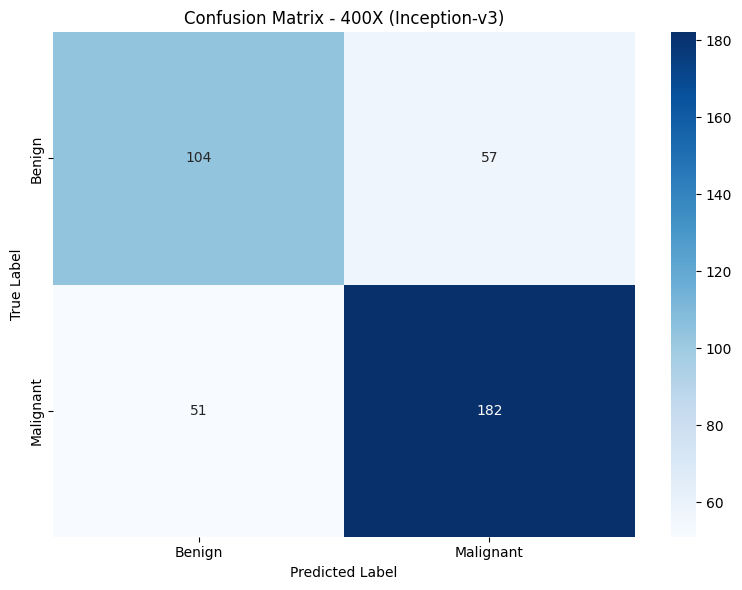


Starting experiment for All...

Training on All magnification with Inception-v3

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch   1: Train Loss: 0.9330, Val Loss: 0.7581, Val AUC: 0.7217


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Epoch   2: Train Loss: 0.8307, Val Loss: 0.6137, Val AUC: 0.7417


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch   3: Train Loss: 0.8073, Val Loss: 0.6781, Val AUC: 0.7646


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Epoch   4: Train Loss: 0.8130, Val Loss: 0.5730, Val AUC: 0.7699


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch   5: Train Loss: 0.7980, Val Loss: 0.5740, Val AUC: 0.7614


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch   6: Train Loss: 0.8030, Val Loss: 0.5996, Val AUC: 0.7490


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Epoch   7: Train Loss: 0.7938, Val Loss: 0.5787, Val AUC: 0.7617


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Epoch   8: Train Loss: 0.7945, Val Loss: 0.5891, Val AUC: 0.7727


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch   9: Train Loss: 0.7922, Val Loss: 0.5765, Val AUC: 0.7679


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  10: Train Loss: 0.7949, Val Loss: 0.6229, Val AUC: 0.7835


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch  11: Train Loss: 0.7910, Val Loss: 0.6442, Val AUC: 0.7599


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch  12: Train Loss: 0.7824, Val Loss: 0.6009, Val AUC: 0.7688


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Epoch  13: Train Loss: 0.7932, Val Loss: 0.6164, Val AUC: 0.7798


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch  14: Train Loss: 0.7829, Val Loss: 0.6065, Val AUC: 0.7837


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch  15: Train Loss: 0.7850, Val Loss: 0.6718, Val AUC: 0.7693


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  16: Train Loss: 0.7926, Val Loss: 0.5959, Val AUC: 0.7940


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  17: Train Loss: 0.7867, Val Loss: 0.6184, Val AUC: 0.7935


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Epoch  18: Train Loss: 0.7868, Val Loss: 0.5743, Val AUC: 0.7914


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  19: Train Loss: 0.7844, Val Loss: 0.5739, Val AUC: 0.7860


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  20: Train Loss: 0.7826, Val Loss: 0.5977, Val AUC: 0.7933


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  21: Train Loss: 0.7900, Val Loss: 0.6178, Val AUC: 0.7855


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Epoch  22: Train Loss: 0.7731, Val Loss: 0.5882, Val AUC: 0.7949


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  23: Train Loss: 0.7809, Val Loss: 0.6174, Val AUC: 0.7905


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  24: Train Loss: 0.7762, Val Loss: 0.5813, Val AUC: 0.7806


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Epoch  25: Train Loss: 0.7778, Val Loss: 0.5743, Val AUC: 0.7898


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Epoch  26: Train Loss: 0.7783, Val Loss: 0.5710, Val AUC: 0.8023


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  27: Train Loss: 0.7792, Val Loss: 0.5555, Val AUC: 0.7965


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch  28: Train Loss: 0.7756, Val Loss: 0.6006, Val AUC: 0.8062


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.00it/s]


Epoch  29: Train Loss: 0.7828, Val Loss: 0.6110, Val AUC: 0.8045


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Epoch  30: Train Loss: 0.7684, Val Loss: 0.6464, Val AUC: 0.7785


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch  31: Train Loss: 0.7811, Val Loss: 0.6045, Val AUC: 0.7962


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  32: Train Loss: 0.7794, Val Loss: 0.5759, Val AUC: 0.7915


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Epoch  33: Train Loss: 0.7732, Val Loss: 0.5595, Val AUC: 0.8075


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Epoch  34: Train Loss: 0.7906, Val Loss: 0.5813, Val AUC: 0.7973


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  35: Train Loss: 0.7864, Val Loss: 0.5942, Val AUC: 0.7985


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  36: Train Loss: 0.7712, Val Loss: 0.5586, Val AUC: 0.7999


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  37: Train Loss: 0.7749, Val Loss: 0.6122, Val AUC: 0.7949


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Epoch  38: Train Loss: 0.7740, Val Loss: 0.5734, Val AUC: 0.7950


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  39: Train Loss: 0.7841, Val Loss: 0.5784, Val AUC: 0.7956


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Epoch  40: Train Loss: 0.7656, Val Loss: 0.5893, Val AUC: 0.7938


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Epoch  41: Train Loss: 0.7687, Val Loss: 0.5730, Val AUC: 0.7979


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch  42: Train Loss: 0.7615, Val Loss: 0.5804, Val AUC: 0.8089


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  43: Train Loss: 0.7506, Val Loss: 0.5843, Val AUC: 0.8116


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch  44: Train Loss: 0.7507, Val Loss: 0.5792, Val AUC: 0.7764


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Epoch  45: Train Loss: 0.7588, Val Loss: 0.5885, Val AUC: 0.8096


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Epoch  46: Train Loss: 0.7575, Val Loss: 0.5941, Val AUC: 0.8055


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Epoch  47: Train Loss: 0.7557, Val Loss: 0.5850, Val AUC: 0.8139


Validation: 100%|██████████| 48/48 [00:24<00:00,  2.00it/s]


Epoch  48: Train Loss: 0.7553, Val Loss: 0.5860, Val AUC: 0.8096


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Epoch  49: Train Loss: 0.7603, Val Loss: 0.5686, Val AUC: 0.8162


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  50: Train Loss: 0.7535, Val Loss: 0.6044, Val AUC: 0.8208

Phase 2: Fine-tuning with unfrozen last conv layers


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch   1: Train Loss: 0.6883, Val Loss: 0.5432, Val AUC: 0.8627


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch   2: Train Loss: 0.6216, Val Loss: 0.5237, Val AUC: 0.9007


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch   3: Train Loss: 0.5917, Val Loss: 0.5266, Val AUC: 0.8817


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Epoch   4: Train Loss: 0.5742, Val Loss: 0.5011, Val AUC: 0.8826


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Epoch   5: Train Loss: 0.5602, Val Loss: 0.5250, Val AUC: 0.8751


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch   6: Train Loss: 0.5477, Val Loss: 0.5171, Val AUC: 0.9111


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch   7: Train Loss: 0.5401, Val Loss: 0.4928, Val AUC: 0.8896


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Epoch   8: Train Loss: 0.5369, Val Loss: 0.4964, Val AUC: 0.9100


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch   9: Train Loss: 0.5288, Val Loss: 0.5050, Val AUC: 0.8987


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Epoch  10: Train Loss: 0.5288, Val Loss: 0.4873, Val AUC: 0.9100


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Epoch  11: Train Loss: 0.5190, Val Loss: 0.4811, Val AUC: 0.9145


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  12: Train Loss: 0.5151, Val Loss: 0.5111, Val AUC: 0.9153


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Epoch  13: Train Loss: 0.5122, Val Loss: 0.4800, Val AUC: 0.9263


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Epoch  14: Train Loss: 0.5141, Val Loss: 0.4877, Val AUC: 0.9193


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Epoch  15: Train Loss: 0.5100, Val Loss: 0.4879, Val AUC: 0.9166


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  16: Train Loss: 0.5022, Val Loss: 0.4981, Val AUC: 0.9076


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Epoch  17: Train Loss: 0.5065, Val Loss: 0.4930, Val AUC: 0.9185


Training:  44%|████▍     | 64/145 [00:48<00:50,  1.60it/s]

In [ ]:
if __name__ == "__main__":
    results = main()